In [1]:
import io
import random

import imageio
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from data_loaders import get_tracking_and_plays
from model import PREPROCESS_MEAN, PREPROCESS_STD, load_expected_yards_model

## Model Predictions

In [2]:
# Load data from week 4
# NOTE: This assumes that train_model.ipynb file has been run to produce the npy files for each week.
test_x_arrays = []
test_y_arrays = []
test_r_arrays = []
test_pos_r_arrays = []
for i in range(4,5):
    print(i)
    cur_x = np.load(f'week_{i}_x_atn.npy')
    cur_y = np.load(f'week_{i}_y_atn.npy')
    cur_r = np.load(f'week_{i}_r_atn.npy')
    cur_pos_r = np.load(f'week_{i}_pos_r_atn.npy')
    test_x_arrays.append(cur_x)
    test_y_arrays.append(cur_y)
    test_r_arrays.append(cur_r)
    test_pos_r_arrays.append(cur_pos_r)
test_x_tensor = np.concatenate(test_x_arrays)
test_y_tensor = np.concatenate(test_y_arrays)
test_r_tensor = np.concatenate(test_r_arrays)
test_pos_r_tensor = np.concatenate(test_pos_r_arrays)

4


In [4]:
# Prepare the data for the model
test_x = torch.tensor(test_x_tensor, dtype=torch.float)
test_pos_r = torch.tensor(test_pos_r_arrays, dtype=torch.double)

# Normalize data according to training set mean
test_x = (test_x - PREPROCESS_MEAN) / PREPROCESS_STD

/var/folders/p5/sdpdzd7s01ngdpvt_xvqmdd80000gn/T/ipykernel_69930/2892243036.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  test_pos_r = torch.tensor(test_pos_r_arrays, dtype=torch.double)


In [5]:
test_dataset = TensorDataset(test_x, test_pos_r.squeeze())

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
# Load the model and run it on all the data
model = load_expected_yards_model()
model.eval()
model.return_attention = True

game_ids = np.zeros((len(test_x)))
play_ids = np.zeros((len(test_x)))
frame_ids = np.zeros((len(test_x)))
yard_preds = np.zeros((len(test_x)))
attention_maps = np.zeros((len(test_x), 11, 10))
attention_ref_def = np.zeros((len(test_x), 11))
attention_ref_off = np.zeros((len(test_x), 10))
cur = 0
with torch.no_grad():
    for cur_x, cur_r in tqdm(test_loader):
        cur_outputs = model(cur_x)
        for i in range(len(cur_outputs[0])):
            game_ids[cur] = cur_r[i][0][0][2]
            play_ids[cur] = cur_r[i][0][0][3]
            frame_ids[cur] = cur_r[i][0][0][4]
            attention_maps[cur] = cur_outputs[3][i] * cur_outputs[2][i] * cur_outputs[1][i]
            attention_ref_def[cur] = cur_r[i][:,0,0]
            attention_ref_off[cur] = cur_r[i][0,:,1]
            yard_preds[cur] = cur_outputs[0][i]
            cur+=1

  0%|          | 0/2317 [00:00<?, ?it/s]

100%|██████████| 2317/2317 [01:06<00:00, 34.73it/s]


In [9]:
# Store model predictions in dataframe
preds = pd.DataFrame({'gameId': game_ids, 'playId': play_ids, 'frameId': frame_ids, 'ExpectedYards': yard_preds, 'AttentionMap': attention_maps.tolist(), 'AttentionRefDef': attention_ref_def.tolist(), 'AttentionRefOff': attention_ref_off.tolist()})

df = get_tracking_and_plays('tracking_week_4.csv')
df = df.merge(preds, how='left', on=['gameId', 'playId', 'frameId'])
df.head()



/Users/danielhocevar/development/bdb_bug/BigDataBowl2024/Code/data_loaders.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_x']=bc_coords['x']
/Users/danielhocevar/development/bdb_bug/BigDataBowl2024/Code/data_loaders.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_y']=bc_coords['y']


,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,is_on_defense,is_ballcarrier,bc_x,bc_y,frameId_start,frameId_end,ExpectedYards,AttentionMap,AttentionRefDef,AttentionRefOff
0,2022092900,57,42654.0,La'el Collins,16,2022-09-29 20:16:01.599999,71.0,CIN,left,34.13,...,False,False,30.36,24.303333,16.0,45.0,6.254380,"[[0.10176374018192291, 0.03634851053357124, 0....","[43321.0, 43327.0, 43503.0, 46142.0, 46312.0, ...","[42654.0, 43344.0, 43510.0, 46094.0, 46163.0, ..."
1,2022092900,57,42654.0,La'el Collins,17,2022-09-29 20:16:01.700000,71.0,CIN,left,34.15,...,False,False,30.58,24.463333,16.0,45.0,6.165869,"[[0.09672700613737106, 0.03968068212270737, 0....","[43321.0, 43327.0, 43503.0, 46142.0, 46312.0, ...","[42654.0, 43344.0, 43510.0, 46094.0, 46163.0, ..."
2,2022092900,57,42654.0,La'el Collins,18,2022-09-29 20:16:01.799999,71.0,CIN,left,34.16,...,False,False,30.84,24.583333,16.0,45.0,5.951019,"[[0.0908566564321518, 0.04263148084282875, 0.0...","[43321.0, 43327.0, 43503.0, 46142.0, 46312.0, ...","[42654.0, 43344.0, 43510.0, 46094.0, 46163.0, ..."
3,2022092900,57,42654.0,La'el Collins,19,2022-09-29 20:16:01.900000,71.0,CIN,left,34.17,...,False,False,31.14,24.643333,16.0,45.0,5.849379,"[[0.08307498693466187, 0.043974678963422775, 0...","[43321.0, 43327.0, 43503.0, 46142.0, 46312.0, ...","[42654.0, 43344.0, 43510.0, 46094.0, 46163.0, ..."
4,2022092900,57,42654.0,La'el Collins,20,2022-09-29 20:16:02.000000,71.0,CIN,left,34.19,...,False,False,31.48,24.673333,16.0,45.0,5.719327,"[[0.07981652766466141, 0.04692748188972473, 0....","[43321.0, 43327.0, 43503.0, 46142.0, 46312.0, ...","[42654.0, 43344.0, 43510.0, 46094.0, 46163.0, ..."


## Animation and Attention Processing

In [150]:
team_colors = {
    'ARI':"#97233F",
    'ATL':"#A71930",
    'BAL':'#241773',
    'BUF':"#00338D",
    'CAR':"#0085CA",
    'CHI':"#C83803",    
    'CIN':"#FB4F14",
    'CLE':"#311D00",
    'DAL':'#003594',
    'DEN':"#FB4F14",
    'DET':"#0076B6",
    'GB':"#203731",
    'HOU':"#03202F",
    'IND':"#002C5F",
    'JAX':"#9F792C",
    'KC':"#E31837",
    'LA':"#0373fc",
    'LAC':"#007FC8",
    'LV':"#000000",
    'MIA':"#008E97",
    'MIN':"#4F2683",
    'NE':"#002244",
    'NO':"#D3BC8D",
    'NYG':"#0B2265",
    'NYJ':"#125740",
    'PHI':"#004C54",
    'PIT':"#FFB612",
    'SEA':"#69BE28",
    'SF':"#ff3643",
    'TB':'#D50A0A',
    'TEN':"#4B92DB",
    'WAS':"#5A1414"
    }

def animate_play(df, gameId, playId):
    games = pd.read_csv('games.csv')
    game = games[games['gameId'] == gameId].iloc[0]
    home_team = game['homeTeamAbbr']
    visitor_team = game['visitorTeamAbbr']

    def create_football_field():
      rect = patches.Rectangle((0, 0), 53.3, 120, linewidth=0.1,
                              facecolor='#f0f2f6ff', zorder=0)
      fig, ax = plt.subplots(figsize=(6, 14))
      ax.add_patch(rect)
      plt.plot([0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
                    53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
                [10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
                    80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
                  color='grey')
      for y in range(20, 110, 10):
        numb = y
        if y > 50:
            numb = 120 - y
        plt.text(5, y-1.5, str(numb - 10),
                  horizontalalignment='center',
                  fontsize=20,  # fontname='Arial',
                  color='grey', rotation=270)
        plt.text(53.3 - 5, y - 0.95, str(numb - 10),
                  horizontalalignment='center',
                  fontsize=20,  # fontname='Arial',
                  color='grey', rotation=90)
      for y in range(11,110):
        ax.plot([0.7, 0.4],[y, y], color='grey')
        ax.plot([53.0, 52.5],[y, y], color='grey')
        ax.plot([22.91, 23.57],[y, y], color='grey')
        ax.plot([29.73, 30.39],[y, y],  color='white')
        homeEndzone = patches.Rectangle((0, 0), 53.3, 10,
                                        linewidth=0.1,
                                        edgecolor='grey',
                                        facecolor=team_colors[home_team],
                                        zorder=0)
        awayEndzone = patches.Rectangle((0, 110), 53.3, 10,
                                        linewidth=0.1,
                                        edgecolor='grey',
                                        facecolor=team_colors[visitor_team],  # Use the team color
                                        zorder=0)
        ax.add_patch(homeEndzone)
        ax.add_patch(awayEndzone)
        ax.set_xticks([])
        ax.set_yticks([])
        return fig, ax

    def plot_frame(frame_num, play_df):
        fig, ax = create_football_field()
        fig_full = plt.figure(figsize=(12, 7))  # Overall figure size
        gs = gridspec.GridSpec(4, 6, width_ratios=[6, 0.6, 1.6, 0.9, 0.65, 12], height_ratios=[2.5, 0.2, 9, 0.4])

        ax6 = fig_full.add_subplot(gs[0:, 1:5])
        ax1 = fig_full.add_subplot(gs[0:, 0])
        ax2 = fig_full.add_subplot(gs[2, 2])
        ax3 = fig_full.add_subplot(gs[2, 3]) 
        ax4 = fig_full.add_subplot(gs[2:, 5])
        ax5 = fig_full.add_subplot(gs[0, 5])
        
        # Adjust whitespace
        fig_full.subplots_adjust(left=0.01, right=0.99, bottom=0.05, top=0.95, wspace=0.05, hspace=0.01)

        # Create a grey background for text for better readability
        textbox_height = 10
        text_box = patches.Rectangle((0, -textbox_height), 53.3, textbox_height,
                                 linewidth=1, edgecolor='none', facecolor='black',
                                 zorder=2, alpha=0.8)
        ax.add_patch(text_box)
        current_frame_df = play_df[play_df['frameId'] == frame_num]
        
        # Display description on ax1
        desc_img = Image.open('Visualizations/Helpers/ma_keys.png')
        ax1.imshow(desc_img)

        caption_img = Image.open('Visualizations/Helpers/ma_caption.png')
        ax5.imshow(caption_img)

        column_img = Image.open('Visualizations/Helpers/ma_column.png')
        ax6.imshow(column_img)
        
        # PROCESS ATTENTION MAP

        # Specify the defensive player to focus on
        def_player_idx = 3 
        def_player_focus_id = current_frame_df['AttentionRefDef'].iloc[0][def_player_idx]

        # Extract the attention map for the defender
        attention_map = current_frame_df['AttentionMap'].iloc[0][def_player_idx]
        off_attention_ref = current_frame_df['AttentionRefOff'].iloc[0]
        display_attention_map = np.array(attention_map).reshape(10, 1)
        ax3.imshow(display_attention_map, cmap='Reds', interpolation='nearest', aspect='auto', zorder=2)
        num_rows, num_cols = display_attention_map.shape
        for i in range(num_rows):
            for j in range(num_cols):
                text = ax3.text(j, i, round(display_attention_map[i, j], 2),
                        ha="center", va="center", color="white", 
                        fontweight='bold')
                # Add black outline to the text
                text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])


        ball_carrier_y_ratio = 0
        def_foccus_x = 0
        def_focus_y = 0
        for index, row in current_frame_df.iterrows():
            if row['nflId'] == def_player_focus_id:
                def_foccus_x = row['x']
                def_focus_y = row['y']

        # Plot players and attention
        for index, row in current_frame_df.iterrows():
            if row['nflId'] in off_attention_ref:
                attention_index = off_attention_ref.index(row['nflId'])
                # Draw the attention for the current player
                cur_player_attention = attention_map[attention_index]
                circle = patches.Ellipse((0.5, 0.1 * (9 - off_attention_ref.index(row['nflId'])) + 0.05), width=0.49, height=0.09, edgecolor='black', facecolor='#faa0a0', zorder=2)
                ax2.add_patch(circle)
                text = ax2.text(0.5, 0.1 * (9 - off_attention_ref.index(row['nflId'])) + 0.05, str(int(row['jerseyNumber'])), ha='center', va='center', color="white", fontweight='bold', zorder=2)
                text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
            else:
                cur_player_attention = -1
                
            if row['nflId'] == def_player_focus_id:
                ax.scatter(row['y'], row['x'], color='blue', s=90, zorder=5)
                ax.text(row['y']- 0.6, row['x'] - 0.5, int(row['jerseyNumber']), fontdict={'size': 6, 'color': 'white'}, zorder=5)
            elif row['is_ballcarrier']:
                ax.scatter(row['y'], row['x'], color='black', s=90, zorder=5)
                ax.text(row['y']- 0.4, row['x'] - 0.6, int(row['jerseyNumber']), fontdict={'size': 6, 'color': 'white'}, zorder=5)
                ball_carrier_y_ratio = row['y'] / 120
            elif cur_player_attention > 0.11:
                ax.scatter(row['y'], row['x'], color='red', s=90, zorder=3)
                # Draw attention line
                ax.plot([def_focus_y, row['y']], [def_foccus_x, row['x']], color='red', linewidth=1, zorder=3)
                ax.text(row['y']- 0.6, row['x'] - 0.5, int(row['jerseyNumber']), fontdict={'size': 6, 'color': 'white'}, zorder=3)
            elif row['is_on_offense'] and not row['is_ballcarrier']:
                ax.scatter(row['y'], row['x'], color='#faa0a0', s=90, zorder=3)
                ax.text(row['y']- 0.6, row['x'] - 0.5, int(row['jerseyNumber']), fontdict={'size': 6, 'color': 'black'},)
            elif row['is_on_defense']:
                ax.scatter(row['y'], row['x'], color='#a0acfa', s=90, zorder=3)
            elif row['club'] == 'football':
                pass

        ax1.axis('off')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

        ax2.axis('off')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])

        ax3.axis('off')
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])

        ax4.axis('off')
        ax4.set_xticks([])
        ax4.set_yticks([])
        ax4.set_xticklabels([])
        ax4.set_yticklabels([])

        ax5.axis('off')
        ax5.set_xticks([])
        ax5.set_yticks([])
        ax5.set_xticklabels([])
        ax5.set_yticklabels([])

        ax6.axis('off')
        ax6.set_xticks([])
        ax6.set_yticks([])
        ax6.set_xticklabels([])
        ax6.set_yticklabels([])

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        image = image[int(image.shape[0] * ball_carrier_y_ratio) - 200 : int(image.shape[0] * ball_carrier_y_ratio) + 200, 70:-70, :]
        ax4.imshow(image)

        legend_elements = [plt.Line2D([0], [0],  marker='o', color='w', label='Ball Carrier', markerfacecolor='black', markersize=7),
                       plt.Line2D([0], [0], marker='o', color='w', label='Defender in Focus', markerfacecolor='blue', markersize=7),
                       plt.Line2D([0], [0], marker='o', color='w', label='High Attention Blocker', markerfacecolor='red', markersize=7),
                       plt.Line2D([0], [0], marker='o', color='w', label='Offensive Player', markerfacecolor='#faa0a0', markersize=7),
                       plt.Line2D([0], [0], marker='o', color='w', label='Defensive Player', markerfacecolor='#a0acfa', markersize=7)]
        legend = ax4.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.175, 0.925), facecolor='#f0f2f6ff', edgecolor='grey', fontsize='x-small', handletextpad=0.2, markerscale=1.2)
        ax4.add_artist(legend)

        fig_full.canvas.draw()
        image = np.frombuffer(fig_full.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig_full.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        plt.close(fig_full)
        return image

    play_df = df[(df['gameId'] == gameId) & (df['playId'] == playId)]
    frame_nums = play_df['frameId'].unique()

    # Generate all frame images
    images = [plot_frame(frame_num, play_df) for frame_num in frame_nums]

    # Create the GIF
    gif_filename = f"gameId: {gameId}, playId: {playId}.gif"
    imageio.mimsave(gif_filename, images, duration=170, loop=0)

In [151]:
animate_play(df, 2022100213	, 3721)

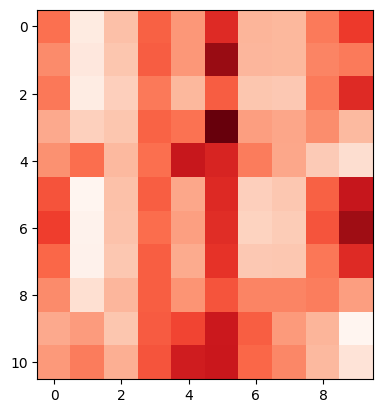

In [163]:
plt.imshow(np.array(df['AttentionMap'].iloc[0]), cmap='Reds')